# ATP Tennis - Feature Engineering with Player and Matchup History for last 5 matches

In previous notebook we created features based on data that was already provided for the match.

In this notebook, we will add to this dataset by created features that represents player matchup and player history as I think this should help us with our model

## Player History

We will create features that represent player matches leading up to that match we are predicting. Not all of these columns will be used in our model - most likely I will only use the percentages in our models but the data is there can we can filter them out later

We are currently only looking back 5 matches leading up to our current match we are trying to predict

### Features Created
* wins - matches won
* losses - matches lost
* games won
* sets won
* games lost
* sets lost
* winning percentage = wins / (wins + losses)
* games won percetnage = games won / (games won + games lost)
* sets won percentage = sets won / (sets won + sets lost)

## Player Matchup
We will create features that represent match-up history - ie, whether p1 defeated p2, score, etc. Currently, we are only looking back up to 5 matchups

## Features Created
* matchups won - ie, out of last 5 matchups - how many matches did p1 win
* matchups lost
* matchups sets won
* matchups sets lost
* matchups games won
* matchups games lost
* matchups win percentage
* matchups sets won percentage
* matchups games won percentage



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json
from datetime import datetime, date
from sys import path
from os.path import dirname as dir
import re
from pprint import pprint
import traceback

import sys
import random
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util.model_util import RSTATE
random.seed(RSTATE)


path.append(dir('../'))

# from util import score_util

# from util.score_util import process_scores
# import importlib
# importlib.reload(util.score_util)

import logging

%matplotlib inline
sns.set()

In [2]:
# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

# Contants
START_YEAR = 1985
END_YEAR = 2019

# number of matches to go back to when we calculate history, matchup, and player stats
# you can use the same notebook to generate features for 10 leading matches
LEADING_MATCHES = [5, 10]

# files
DATASET_DIR = '../datasets'
# this is the file we generated from our pre-processing notebook
PREPROCESSED_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_preprocessed.csv'

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
# see generate_history10.sh
DEBUG = bool(os.environ.get("IPYNB_DEBUG", True))

if DEBUG:
    PREPROCESSED_FILE = f'{DATASET_DIR}/test-preprocessed.csv'
    FEATURE_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test.csv'
    FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-diff.csv'
    FEATURE_FILE_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-ohe.csv'
    FEATURE_FILE_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-diff-ohe.csv'
    FEATURE_FILE_RAW_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-raw_diff-ohe.csv'
    PLAYER_STATS_FILE = f'{DATASET_DIR}/test-player_stats.csv'
else:
    # this is the file we generated from our pre-processing notebook
    PREPROCESSED_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_preprocessed.csv'
    FEATURE_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features.csv'
    FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-diff.csv'
    FEATURE_FILE_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-ohe.csv'
    FEATURE_FILE_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-diff-ohe.csv'
    FEATURE_FILE_RAW_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-raw_diff-ohe.csv'
    PLAYER_STATS_FILE = f'{DATASET_DIR}/player_stats.csv'


# FEATURE_FILE_1985 = f'{DATASET_DIR}/atp_matches_1985-2019_features.csv'
# FEATURE_FILE_1985_OHE = f'{DATASET_DIR}/atp_matches_1985-2019_features-ohe.csv'
# FEATURE_FILE_1985_DIFF = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff.csv'
# FEATURE_FILE_1985_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-ohe.csv'

# output info
MODEL_DIR = '../models'

REPORT_DIR = '../reports'
REFPORT_FILE = f'{REPORT_DIR}/report.csv'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 1000



In [3]:
preprocessed = pd.read_csv(PREPROCESSED_FILE, parse_dates=["tourney_date"])
# load this small feature file so we can use the winner placement later
feature1985 = pd.read_csv(FEATURE_FILE)

# Let's prepare some DF's for our stats

We will create 3 DF's here

* stats_all - this will be a list of all matches played with stats so we can calculate leading stats later
* stats_avg - all time average player stats


## First we will create stats history

We will take all winner stats columns and loser stats columns and concatenate them into one data frame
This dataframe will be stored by tourney_date

We will also calculate some new stats:

* ace percentage = ace / svpt
* bp save percentage = bpsaved / bpfaced
* 1st percentage = 1stin / svpt

In [4]:
winner_stats_map_dict = {
    "winner_id": "player_id",
    "w_ace": "stats_ace",
    "w_df": "stats_df",
    "w_svpt": "stats_svpt",
    "w_1stin": "stats_1stin",
    "w_1stwon": "stats_1stwon",
    "w_2ndwon": "stats_2ndwon",
    "w_svgms": "stats_svgms",
    "w_bpsaved": "stats_bpsaved",
    "w_bpfaced": "stats_bpfaced"
}
loser_stats_map_dict = {
    "loser_id": "player_id",
    "l_ace": "stats_ace",
    "l_df": "stats_df",
    "l_svpt": "stats_svpt",
    "l_1stin": "stats_1stin",
    "l_1stwon": "stats_1stwon",
    "l_2ndwon": "stats_2ndwon",
    "l_svgms": "stats_svgms",
    "l_bpsaved": "stats_bpsaved",
    "l_bpfaced": "stats_bpfaced"
}
winner_stats = preprocessed[["winner_id",
                    "w_ace",
                    "w_df",
                    "w_svpt",
                    "w_1stin",
                    "w_1stwon",
                    "w_2ndwon",
                    "w_svgms",
                    "w_bpsaved",
                    "w_bpfaced",
                   "tourney_date"]].rename(winner_stats_map_dict, axis=1)
print(f'Winners shape: {winner_stats.shape}')

# winner_stats.head()

loser_stats = preprocessed[["loser_id",
                    "l_ace",
                    "l_df",
                    "l_svpt",
                    "l_1stin",
                    "l_1stwon",
                    "l_2ndwon",
                    "l_svgms",
                    "l_bpsaved",
                    "l_bpfaced",
                   "tourney_date"]].rename(loser_stats_map_dict, axis=1)
print(f'Losers shape: {loser_stats.shape}')

# combine the df's and then sort by tourney_date and reset the index
stats_all = pd.concat([winner_stats, loser_stats], axis=0).sort_values("tourney_date").reset_index(drop=True)

# some stats columns have no data (na), we will impute them here with the mean of the column
stats_all = stats_all.apply(lambda x: x.fillna(x.mean()),axis=0)

# convert all types to int
type_map = { col: np.int32 for col in stats_all.columns if col != "tourney_date"  }

stats_all = stats_all.astype(type_map)

# calculate some new stats
stats_all["stats_ace_percentage"] = stats_all["stats_ace"] / stats_all["stats_svpt"] if stats_all["stats_svpt"].values[0] > 0 else 0
stats_all["stats_1stin_percentage"] = stats_all["stats_1stin"] / stats_all["stats_svpt"] if stats_all["stats_svpt"].values[0] > 0 else 0
stats_all["stats_bpsaved_percentage"] = stats_all["stats_bpsaved"] / stats_all["stats_bpfaced"] if stats_all["stats_bpfaced"].values[0] > 0 else 0
stats_all.head()

stats_all.to_csv(PLAYER_STATS_FILE, index=False)

print(f'Final shape: {stats_all.shape}')
stats_all.info()

Winners shape: (100, 11)
Losers shape: (100, 11)
Final shape: (200, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
player_id                   200 non-null int32
stats_ace                   200 non-null int32
stats_df                    200 non-null int32
stats_svpt                  200 non-null int32
stats_1stin                 200 non-null int32
stats_1stwon                200 non-null int32
stats_2ndwon                200 non-null int32
stats_svgms                 200 non-null int32
stats_bpsaved               200 non-null int32
stats_bpfaced               200 non-null int32
tourney_date                200 non-null datetime64[ns]
stats_ace_percentage        200 non-null float64
stats_1stin_percentage      200 non-null float64
stats_bpsaved_percentage    186 non-null float64
dtypes: datetime64[ns](1), float64(3), int32(10)
memory usage: 14.2 KB


### Looks like we now have some NaN values that we didn't before. Let's look at why

Looks like divide by 0 with pandas gives us NaN so we can imput this with 0

In [5]:
stats_all.loc[stats_all.stats_bpsaved_percentage.isna()].sample(5)

,player_id,stats_ace,stats_df,stats_svpt,stats_1stin,stats_1stwon,stats_2ndwon,stats_svgms,stats_bpsaved,stats_bpfaced,tourney_date,stats_ace_percentage,stats_1stin_percentage,stats_bpsaved_percentage
197,124187,16,0,49,36,33,8,10,0,0,2019-01-07,0.326531,0.734694,NaN
73,104925,3,2,42,26,21,11,8,0,0,2018-12-31,0.071429,0.619048,NaN
79,104527,5,1,61,30,28,20,11,0,0,2018-12-31,0.081967,0.491803,NaN
48,104731,21,6,104,65,57,26,18,0,0,2018-12-31,0.201923,0.625000,NaN
186,200282,3,1,60,33,29,19,11,0,0,2019-01-07,0.050000,0.550000,NaN


In [6]:
stats_all[(stats_all.stats_bpsaved_percentage.isna()) & (stats_all.stats_bpfaced != 0)]

,player_id,stats_ace,stats_df,stats_svpt,stats_1stin,stats_1stwon,stats_2ndwon,stats_svgms,stats_bpsaved,stats_bpfaced,tourney_date,stats_ace_percentage,stats_1stin_percentage,stats_bpsaved_percentage


In [7]:
stats_all = stats_all.fillna(0)
stats_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
player_id                   200 non-null int32
stats_ace                   200 non-null int32
stats_df                    200 non-null int32
stats_svpt                  200 non-null int32
stats_1stin                 200 non-null int32
stats_1stwon                200 non-null int32
stats_2ndwon                200 non-null int32
stats_svgms                 200 non-null int32
stats_bpsaved               200 non-null int32
stats_bpfaced               200 non-null int32
tourney_date                200 non-null datetime64[ns]
stats_ace_percentage        200 non-null float64
stats_1stin_percentage      200 non-null float64
stats_bpsaved_percentage    200 non-null float64
dtypes: datetime64[ns](1), float64(3), int32(10)
memory usage: 14.2 KB


## Let's check to make sure all values are > 0

The first one is clearly a mistake - set stats_bpsaved to 0
The second one is probably as mistake as well, set this to positive

In [8]:
stats_all[ (stats_all.stats_ace_percentage < 0) | (stats_all.stats_1stin_percentage < 0) | (stats_all.stats_bpsaved_percentage < 0)]

,player_id,stats_ace,stats_df,stats_svpt,stats_1stin,stats_1stwon,stats_2ndwon,stats_svgms,stats_bpsaved,stats_bpfaced,tourney_date,stats_ace_percentage,stats_1stin_percentage,stats_bpsaved_percentage


In [9]:
stats_all.loc[34473, "stats_bpsaved_percentage"] = 0
stats_all.loc[34473, "stats_bpsaved"] = 0
stats_all.loc[34474, "stats_bpsaved_percentage"] = 3
stats_all.loc[34474, "stats_bpsaved"] = 6
stats_all[ (stats_all.stats_ace_percentage < 0) | (stats_all.stats_1stin_percentage < 0) | (stats_all.stats_bpsaved_percentage < 0)]

,player_id,stats_ace,stats_df,stats_svpt,stats_1stin,stats_1stwon,stats_2ndwon,stats_svgms,stats_bpsaved,stats_bpfaced,tourney_date,stats_ace_percentage,stats_1stin_percentage,stats_bpsaved_percentage


## Now we create all time average stats for each player

In [10]:
stats_avg_mapper_dict = {
    "stats_ace": "stats_ace_avg",
    "stats_df": "stats_df_avg",
    "stats_svpt": "stats_svpt_avg",
    "stats_1stin": "stats_1stin_avg",
    "stats_1stwon": "stats_1stwon_avg",
    "stats_2ndwon": "stats_2ndwon_avg",
    "stats_svgms": "stats_svgms_avg",
    "stats_bpsaved": "stats_bpsaved_avg",
    "stats_bpfaced": "stats_bpfaced_avg",
    "stats_ace_percentage": "stats_ace_percentage_avg",
    "stats_bpsaved_percentage": "stats_bpsaved_percentage_avg",
    "stats_1stin_percentage": "stats_1stin_percentage_avg"
}

stats_avg = stats_all.groupby("player_id").mean().rename(stats_avg_mapper_dict, axis=1).reset_index()
stats_avg

,player_id,stats_ace_avg,stats_df_avg,stats_svpt_avg,stats_1stin_avg,stats_1stwon_avg,stats_2ndwon_avg,stats_svgms_avg,stats_bpsaved_avg,stats_bpfaced_avg,stats_ace_percentage_avg,stats_1stin_percentage_avg,stats_bpsaved_percentage_avg
0,103333.0,24.800000,3.000000,79.2,54.2,47.400000,14.600000,13.600000,2.400000,2.600000,0.309355,0.680406,0.500000
1,103970.0,1.500000,0.500000,25.5,18.5,13.000000,5.000000,4.000000,1.000000,1.500000,0.037500,0.759091,0.750000
2,104198.0,2.333333,2.666667,61.0,38.0,22.666667,9.333333,9.333333,5.333333,9.333333,0.038288,0.628867,0.559524
3,104259.0,2.000000,1.000000,54.0,34.0,26.500000,12.500000,9.500000,1.750000,2.750000,0.041027,0.635498,0.406250
4,104269.0,9.000000,3.000000,113.0,75.0,50.000000,16.000000,15.000000,10.000000,14.000000,0.079646,0.663717,0.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,144719.0,3.666667,1.000000,56.0,40.0,28.000000,7.333333,9.333333,3.000000,5.000000,0.068719,0.704733,0.300000
85,200000.0,7.000000,3.000000,56.0,39.0,30.000000,9.000000,11.000000,0.000000,2.000000,0.125000,0.696429,0.000000
86,200005.0,5.000000,3.000000,59.5,35.5,25.500000,13.500000,10.000000,3.500000,5.000000,0.084511,0.596382,0.625000
87,200282.0,2.400000,1.200000,68.2,43.2,33.200000,13.800000,10.600000,2.200000,3.400000,0.034767,0.625159,0.447619


## We will use this function to get stats for our players later

In [11]:
stats_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 13 columns):
player_id                       89 non-null float64
stats_ace_avg                   89 non-null float64
stats_df_avg                    89 non-null float64
stats_svpt_avg                  89 non-null float64
stats_1stin_avg                 89 non-null float64
stats_1stwon_avg                89 non-null float64
stats_2ndwon_avg                89 non-null float64
stats_svgms_avg                 89 non-null float64
stats_bpsaved_avg               89 non-null float64
stats_bpfaced_avg               89 non-null float64
stats_ace_percentage_avg        89 non-null float64
stats_1stin_percentage_avg      89 non-null float64
stats_bpsaved_percentage_avg    89 non-null float64
dtypes: float64(13)
memory usage: 9.2 KB


In [12]:
stats_avg.describe()

,player_id,stats_ace_avg,stats_df_avg,stats_svpt_avg,stats_1stin_avg,stats_1stwon_avg,stats_2ndwon_avg,stats_svgms_avg,stats_bpsaved_avg,stats_bpfaced_avg,stats_ace_percentage_avg,stats_1stin_percentage_avg,stats_bpsaved_percentage_avg
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,113019.629213,6.297753,2.847378,75.533708,47.243258,33.659176,14.154682,11.691948,3.826404,6.332397,0.082823,0.623246,0.531526
std,20614.460488,4.815253,1.786992,17.011164,11.683932,9.143114,4.295190,2.276556,2.101372,2.597423,0.062450,0.065601,0.198654
min,103333.000000,0.000000,0.000000,25.500000,18.500000,13.000000,5.000000,4.000000,0.000000,1.500000,0.000000,0.475410,0.000000
25%,104925.000000,3.000000,1.666667,64.000000,39.750000,27.750000,11.400000,10.000000,2.500000,4.500000,0.040816,0.587327,0.428571
50%,105614.000000,5.666667,2.500000,73.000000,46.000000,34.333333,14.000000,11.500000,3.500000,6.000000,0.072871,0.630137,0.559524
75%,111202.000000,8.000000,4.000000,86.500000,53.666667,40.000000,17.000000,13.000000,5.333333,8.000000,0.099364,0.665152,0.666667
max,200615.000000,26.000000,8.000000,113.000000,78.000000,52.500000,27.000000,17.000000,11.000000,16.000000,0.309524,0.759091,0.893333


In [13]:
import util.score_util as su
import importlib
importlib.reload(su)


logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

# def process_scores(scores: str, idx: str = None):
#     """
#     Use this to parse out differnt parts of a match score.
#     Will be using this for feature Engineering as input to predict match results

#     :param scores: - string with scores - ie, 6-7 7-6(7) 6-3
#     "param idx": - optional entry with row index - used for debugging since some of the scores look to have been converted to date (ie, 3-jun)

#     :return:
#         winner_sets_won
#         winner_games_won
#         loser_sets_won
#         loser_games_won
#     """
#     scores_orig = scores
#     set_score = [0, 0]
#     game_score = [0, 0]
#     try:
#         scores = re.sub(r"[^0-9-\ ]","", scores).strip()
#         log.debug(f'scores {scores_orig} cleaned scores {scores}')
#         sets = scores.split()
#         for set in sets:
#             p1 = int(set.split("-")[0])
#             p2 = int(set.split("-")[1])
#             game_score[0] += p1
#             game_score[1] += p2
#             if p1 > p2:
#                 set_score[0] += 1
#             else:
#                 set_score[1] += 1
#     except Exception as e:
#         raise Exception(f'orig score {scores_orig} scores {scores}') from e
        

#     return set_score[0], game_score[0], set_score[1], game_score[1]

# def get_player_matches(matches: pd.DataFrame, player_id: str, tourney_date: datetime, num_matches: int):
#     return matches[((matches.winner_id == player_id) | (matches.loser_id == player_id)) &
#                   (matches.score.notnull()) &
#                   (matches.tourney_date < tourney_date)][-num_matches:]

# def get_match_ups(matches: pd.DataFrame, p1_id: str, p2_id: str, tourney_date: datetime, num_matches: int):
#     matchups = matches[
#         (((matches.winner_id == p1_id) & (matches.loser_id == p2_id)) |
#         ((matches.winner_id == p2_id) & (matches.loser_id == p1_id))) &
#         (matches.tourney_date < tourney_date) &
#         (matches.score.notnull())
#     ][-num_matches:]
#     return matchups


def get_player_stats(p1_id: int, p1_prefix: str, p2_id: int, p2_prefix: str,  match_date, stats: pd.DataFrame, stats_avg: pd.DataFrame, match_num: int) -> dict:
    """
    gets player stats for match_num leading up to current match and all time player stats
    :param p1_id - player 1 id
    :param p1_prefix - player 1 prefix to name our columns
    :param p2_id - player 2 id
    :param p2_prefix - player 2 prefix to name our columns
    :param date - get stats for matches before this date
    :param stats - all time stats DF
    :param stats_avg - all time average stats DF
    :return: dict with all features as keys
    """
    p1_id = int(p1_id)
    p2_id = int(p2_id)
    
    d = {}
    # first we will get all leading player stats
    p1_leading_match_stats = stats[(stats.player_id == p1_id) & (stats.tourney_date < match_date)].tail(match_num).mean()
    p2_leading_match_stats = stats[(stats.player_id == p2_id) & (stats.tourney_date < match_date)].tail(match_num).mean()
    
    p1_d = { f'{p1_prefix}_{col_name.replace("stats", f"stats{match_num}")}': value for col_name, value in p1_leading_match_stats.iteritems() if col_name not in ["player_id", "tourney_date"]}
    p2_d = { f'{p2_prefix}_{col_name.replace("stats", f"stats{match_num}")}': value for col_name, value in p2_leading_match_stats.iteritems() if col_name not in ["player_id", "tourney_date"]}
    d.update(p1_d)
    d.update(p2_d)
    
    # create diff data for leading player stats
    p1_diff_d = { f'{col_name}_diff': value - p2_d[col_name.replace(p1_prefix, p2_prefix)] for col_name, value in p1_d.items()}
    d.update(p1_diff_d)
    
    # now we get all time average stats
    
    # these are floats, so we have ot use values[0]
    p1_avg_d = { f'{p1_prefix}_{col_name}': value.values[0] for col_name, value in stats_avg[stats_avg.player_id == p1_id].iteritems() if col_name != "player_id"}
        
    d.update(p1_avg_d)
    p2_avg_d = { f'{p2_prefix}_{col_name}': value.values[0] for col_name, value in stats_avg[stats_avg.player_id == p2_id].iteritems() if col_name != "player_id"}
    d.update(p2_avg_d)
    
    # create diff data
    p1_avg_diff_d = { f'{col_name}_diff': value - p2_avg_d[col_name.replace(p1_prefix, p2_prefix)] for col_name, value in p1_avg_d.items()}
    d.update(p1_avg_diff_d)
    
    return d


def get_player_history(p1_id, p1_prefix, p2_id, p2_prefix, match_date, preprocessed: pd.DataFrame, num_matches: int) -> dict:

    
    p1_history_wins, p1_history_losses, p1_history_sets_won, p1_history_games_won, p1_history_sets_lost, p1_history_games_lost = 0, 0, 0, 0, 0, 0
    p2_history_wins, p2_history_losses, p2_history_sets_won, p2_history_games_won, p2_history_sets_lost, p2_history_games_lost = 0, 0, 0, 0, 0, 0

    matches = preprocessed[((preprocessed.winner_id == p1_id) | (preprocessed.loser_id == p1_id)) &
                  (preprocessed.score.notnull()) &
                  (preprocessed.tourney_date < match_date)][-num_matches:]
    
    # get player 1 history
    for index, match in matches.iterrows():
#     for index, match in get_player_matches(preprocessed, row.p1, 
#                                            match_date, matches).iterrows():
        log.debug(f'index {index} p1 {p1_id}')
        if match.winner_id == p1_id:
            log.debug('p1 winner')
            p1_history_wins += 1
            ws, wg, ls, lg, _, _ = su.process_scores(match.score, index)
            p1_history_sets_won += ws
            p1_history_games_won += wg
            p1_history_sets_lost += ls
            p1_history_games_lost += lg
        else:
            log.debug('p1 loser')
            p1_history_losses += 1
            ws, wg, ls, lg, _, _ = su.process_scores(match.score, index)
            p1_history_sets_won += ls
            p1_history_games_won += lg
            p1_history_sets_lost += ws
            p1_history_games_lost += wg

    # get player 2 history
    matches = preprocessed[((preprocessed.winner_id == p2_id) | (preprocessed.loser_id == p2_id)) &
                  (preprocessed.score.notnull()) &
                  (preprocessed.tourney_date < match_date)][-num_matches:]

    for index, match in matches.iterrows():
#     for index, match in get_player_matches(preprocessed, p2_id, 
#                                            match_date, LEADING_MATCHES).iterrows():
        log.debug(f'index {index} p2 {p2_id}')
        if match.winner_id == p2_id:
            log.debug('p2 winner')
            p2_history_wins += 1
            ws, wg, ls, lg, _, _ = su.process_scores(match.score, index)
            p2_history_sets_won += ws
            p2_history_games_won += wg
            p2_history_sets_lost += ls
            p2_history_games_lost += lg
        else:
            log.debug('p2 loser')
            p2_history_losses += 1
            ws, wg, ls, lg, _, _ = su.process_scores(match.score, index)
            p2_history_sets_won += ls
            p2_history_games_won += lg
            p2_history_sets_lost += ws
            p2_history_games_lost += wg    

    d = {
        f"{p1_prefix}_history{num_matches}_wins": p1_history_wins,
        f"{p1_prefix}_history{num_matches}_losses": p1_history_losses,
        f"{p1_prefix}_history{num_matches}_sets_won": p1_history_sets_won,
        f"{p1_prefix}_history{num_matches}_games_won": p1_history_games_won,
        f"{p1_prefix}_history{num_matches}_sets_lost": p1_history_sets_lost,
        f"{p1_prefix}_history{num_matches}_games_lost": p1_history_games_lost,
        f"{p1_prefix}_history{num_matches}_win_percentage": 0 if p1_history_wins == 0 & p1_history_losses == 0 else p1_history_wins / (p1_history_wins + p1_history_losses),
        f"{p1_prefix}_history{num_matches}_games_won_percentage": 0 if p1_history_games_won == 0 & p1_history_games_lost == 0 else p1_history_games_won / (p1_history_games_won + p1_history_games_lost),
        f"{p1_prefix}_history{num_matches}_sets_won_percentage": 0 if p1_history_sets_won == 0 & p1_history_sets_lost == 0 else p1_history_sets_won / (p1_history_sets_won + p1_history_sets_lost),

        f"{p2_prefix}_history{num_matches}_wins": p2_history_wins,
        f"{p2_prefix}_history{num_matches}_losses": p2_history_losses,
        f"{p2_prefix}_history{num_matches}_sets_won": p2_history_sets_won,
        f"{p2_prefix}_history{num_matches}_games_won": p2_history_games_won,
        f"{p2_prefix}_history{num_matches}_sets_lost": p2_history_sets_lost,
        f"{p2_prefix}_history{num_matches}_games_lost": p2_history_games_lost,
        f"{p2_prefix}_history{num_matches}_win_percentage": 0 if p2_history_wins == 0 & p2_history_losses == 0 else p2_history_wins / (p2_history_wins + p2_history_losses),
        f"{p2_prefix}_history{num_matches}_games_won_percentage": 0 if p2_history_games_won == 0 & p2_history_games_lost == 0 else p2_history_games_won / (p2_history_games_won + p2_history_games_lost),
        f"{p2_prefix}_history{num_matches}_sets_won_percentage": 0 if p2_history_sets_won == 0 & p2_history_sets_lost == 0 else p2_history_sets_won / (p2_history_sets_won + p2_history_sets_lost),
    }
    
    scores[f"{p1_prefix}_history{num_matches}_win_percentage_diff"] = d[f"{p1_prefix}_history{num_matches}_win_percentage"] - d[f"{p2_prefix}_history{num_matches}_win_percentage"]
    scores[f"{p1_prefix}_history{num_matches}_games_won_percentage_diff"] = d[f"{p1_prefix}_history{num_matches}_games_won_percentage"] - d[f"{p2_prefix}_history{num_matches}_games_won_percentage"]
    scores[f"{p1_prefix}_history{num_matches}_sets_won_percentage_diff"] = d[f"{p1_prefix}_history{num_matches}_sets_won_percentage"] - d[f"{p2_prefix}_history{num_matches}_sets_won_percentage"]
    scores[f"{p1_prefix}_history{num_matches}_wins_diff"] = d[f"{p1_prefix}_history{num_matches}_wins"] - d[f"{p2_prefix}_history{num_matches}_wins"]
    scores[f"{p1_prefix}_history{num_matches}_losses_diff"] = d[f"{p1_prefix}_history{num_matches}_losses"] - d[f"{p2_prefix}_history{num_matches}_losses"]

    scores[f"{p1_prefix}_history{num_matches}_matches"] = d[f"{p1_prefix}_history{num_matches}_wins"] + d[f"{p1_prefix}_history{num_matches}_losses"]
    scores[f"{p2_prefix}_history{num_matches}_matches"] = d[f"{p2_prefix}_history{num_matches}_wins"] + d[ f"{p2_prefix}_history{num_matches}_losses"]
    
    
    return d

def get_player_matchups(p1_id, p1_prefix, p2_id, p2_prefix, match_date, preprocessed: pd.DataFrame, num_matches: int) -> dict:

    # get match-up info
#     matchups = get_match_ups(preprocessed, row.p1, row.p2, 
#                                       match_date, LEADING_MATCHES).iterrows()
    p1_matchup_wins, p1_matchup_losses, p1_matchup_sets_won, p1_matchup_games_won = 0, 0, 0, 0
    p2_matchup_wins, p2_matchup_losses, p2_matchup_sets_won, p2_matchup_games_won = 0, 0, 0, 0


    matchups = preprocessed[
        (((preprocessed.winner_id == p1_id) & (preprocessed.loser_id == p2_id)) |
        ((preprocessed.winner_id == p2_id) & (preprocessed.loser_id == p1_id))) &
        (preprocessed.tourney_date < match_date) &
        (preprocessed.score.notnull())
        ][-num_matches:]

    for index, match in matchups.iterrows():
        if match.winner_id == p1_id:
            # p1 was winner in this matchup
            log.debug('p1 matchup winner')
            p1_matchup_wins += 1
            p2_matchup_losses += 1
            ws, wg, ls, lg, _, _ = process_scores(match.score, index)
            p1_matchup_sets_won += ws
            p1_matchup_games_won += wg
            p2_matchup_sets_won += ls
            p2_matchup_games_won += lg
        elif match.winner_id == p2_id:
            log.debug('p2 matchup winner')
            # p2 was the winner in this matchup
            p2_matchup_wins += 1
            p1_matchup_losses += 1
            ws, wg, ls, lg, _, _ = process_scores(match.score, index)
            p2_matchup_sets_won += ws
            p2_matchup_games_won += wg
            p1_matchup_sets_won += ls
            p1_matchup_games_won += lg
        # last matchup date as feature

    d = {

        f"{p1_prefix}_matchup{num_matches}_wins": p1_matchup_wins,
        f"{p1_prefix}_matchup{num_matches}_losses": p1_matchup_losses,
        f"{p1_prefix}_matchup{num_matches}_sets": p1_matchup_sets_won,
        f"{p1_prefix}_matchup{num_matches}_games": p1_matchup_games_won,
        f"{p1_prefix}_matchup{num_matches}_win_percentage": 0 if p1_matchup_wins == 0 & p2_matchup_wins == 0 else p1_matchup_wins / (p1_matchup_wins + p2_matchup_wins),
        f"{p1_prefix}_matchup{num_matches}_sets_won_percentage": 0 if p1_matchup_sets_won == 0 & p2_matchup_sets_won == 0 else p1_matchup_sets_won / (p1_matchup_sets_won + p2_matchup_sets_won),
        f"{p1_prefix}_matchup{num_matches}_games_won_percentage": 0 if p1_matchup_games_won == 0 & p2_matchup_games_won == 0 else p1_matchup_games_won / (p1_matchup_games_won + p2_matchup_games_won),

        f"{p2_prefix}_matchup{num_matches}_wins": p2_matchup_wins,
        f"{p2_prefix}_matchup{num_matches}_losses": p2_matchup_losses,
        f"{p2_prefix}_matchup{num_matches}_sets": p2_matchup_sets_won,
        f"{p2_prefix}_matchup{num_matches}_games": p2_matchup_games_won,
        f"{p2_prefix}_matchup{num_matches}_win_percentage": 0 if p1_matchup_wins == 0 & p2_matchup_wins == 0 else p2_matchup_wins / (p1_matchup_wins + p2_matchup_wins),
        f"{p2_prefix}_matchup{num_matches}_sets_won_percentage": 0 if p1_matchup_sets_won == 0 & p2_matchup_sets_won == 0 else p2_matchup_sets_won / (p1_matchup_sets_won + p2_matchup_sets_won),
        f"{p2_prefix}_matchup{num_matches}_games_won_percentage": 0 if p1_matchup_games_won == 0 & p2_matchup_games_won == 0 else p2_matchup_games_won / (p1_matchup_games_won + p2_matchup_games_won),


    }    
    
    scores[f"{p1_prefix}_matchup{num_matches}_wins_diff"] = d[f"{p1_prefix}_matchup{num_matches}_wins"] - d[f"{p2_prefix}_matchup{num_matches}_wins"]
    scores[f"{p1_prefix}_matchup{num_matches}_games_diff"] = d[f"{p1_prefix}_matchup{num_matches}_games"] - d[f"{p2_prefix}_matchup{num_matches}_games"]
    scores[f"{p1_prefix}_matchup{num_matches}_sets_diff"] = d[f"{p1_prefix}_matchup{num_matches}_sets"] - d[f"{p2_prefix}_matchup{num_matches}_sets"]

    return d
        
scores = pd.DataFrame()
for index, row in feature1985.iterrows():
    # get player record leading up to this match
    log.debug(f'index {index} tourney_year {row.tourney_year} tourney_month {row.tourney_month}')


    match_date = datetime(int(row.tourney_year), int(row.tourney_month), 1)

    d = {}
    for num_matches in LEADING_MATCHES:
        # call get player history and matchups
        d.update(get_player_history(row.p1, "p1", row.p2, "p2", match_date, preprocessed, num_matches))
        d.update(get_player_matchups(row.p1, "p1", row.p2, "p2", match_date, preprocessed, num_matches))

        # now we append player stats
        d.update(get_player_stats(row.p1, "p1", row.p2, "p2", match_date, stats_all, stats_avg, num_matches))




    scores = scores.append(d, ignore_index=True)

    # calculate other columns            
# scores["p1_history_win_percentage_diff"] = scores.p1_history_win_percentage - scores.p2_history_win_percentage
# scores["p1_history_games_won_percentage_diff"] = scores.p1_history_games_won_percentage - scores.p2_history_games_won_percentage
# scores["p1_history_sets_won_percentage_diff"] = scores.p1_history_sets_won_percentage - scores.p2_history_sets_won_percentage
# scores["p1_history_wins_diff"] = scores.p1_history_wins - scores.p2_history_wins
# scores["p1_history_losses_diff"] = scores.p1_history_losses - scores.p2_history_losses

# scores["p1_history_matches"] = scores.p1_history_wins + scores.p1_history_losses
# scores["p2_history_matches"] = scores.p2_history_wins + scores.p2_history_losses


# scores["p1_matchup_wins_diff"] = scores.p1_matchup_wins - scores.p2_matchup_wins
# scores["p1_matchup_games_diff"] = scores.p1_matchup_games - scores.p2_matchup_games
# scores["p1_matchup_sets_diff"] = scores.p1_matchup_sets - scores.p2_matchup_sets        

# re-order columns so it's easier to read
scores = scores.reindex(sorted(scores.columns), axis=1)


pd.set_option('display.max_rows', 500)

scores.sample(5).T


        
    

,53,59,55,9,24
p1_history10_games_lost,25.000000,0.000000,0.000000,0.000000,0.000000
p1_history10_games_won,26.000000,0.000000,0.000000,0.000000,0.000000
p1_history10_games_won_percentage,0.509804,0.000000,0.000000,0.000000,0.000000
p1_history10_games_won_percentage_diff,-0.315789,-0.315789,-0.315789,-0.315789,-0.315789
p1_history10_losses,1.000000,0.000000,0.000000,0.000000,0.000000
p1_history10_losses_diff,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
p1_history10_matches,0.000000,0.000000,0.000000,0.000000,0.000000
p1_history10_sets_lost,2.000000,0.000000,0.000000,0.000000,0.000000
p1_history10_sets_won,2.000000,0.000000,0.000000,0.000000,0.000000
p1_history10_sets_won_percentage,0.500000,0.000000,0.000000,0.000000,0.000000


# Looks like if there is no history when we do mean in pandas, it's giving us NaN

We will impute these with 0

In [14]:
len(scores[scores.p2_history5_matches > 0])

99

In [15]:
len(scores[scores.p2_stats5_svpt.isna()])

87

In [16]:
scores[(scores.p2_stats5_df.isna()) & (scores.p2_history5_matches > 0)][[col for col in scores.columns if re.search("history5", col)]]

,p1_history5_games_lost,p1_history5_games_won,p1_history5_games_won_percentage,p1_history5_games_won_percentage_diff,p1_history5_losses,p1_history5_losses_diff,p1_history5_matches,p1_history5_sets_lost,p1_history5_sets_won,p1_history5_sets_won_percentage,...,p2_history5_games_lost,p2_history5_games_won,p2_history5_games_won_percentage,p2_history5_losses,p2_history5_matches,p2_history5_sets_lost,p2_history5_sets_won,p2_history5_sets_won_percentage,p2_history5_win_percentage,p2_history5_wins
0,0.0,0.0,0.000000,-0.315789,0.0,-1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,-0.315789,0.0,-1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,-0.315789,0.0,-1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,-0.315789,0.0,-1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,-0.315789,0.0,-1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,-0.315789,0.0,-1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,-0.315789,0.0,-1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000,-0.315789,0.0,-1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.000000,-0.315789,0.0,-1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.000000,-0.315789,0.0,-1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
scores = scores.fillna(0)

## Creating rows from dict, pandas automatically casts all numbers into float types. We want to convert ints back into integers to save space

In [18]:
non_percentage_col_dict = {col: np.int32 for col in scores.columns if not re.search(r'(percent|avg)', col)}
scores = scores.astype(non_percentage_col_dict)
scores.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 192 entries, p1_history10_games_lost to p2_stats_svpt_avg
dtypes: float64(84), int32(108)
memory usage: 107.9 KB


# Save off our new feature files

We are going to take existing feature files and add the columns we just generated into these files by concatenating them to the right

In [19]:
def concat_dfs(filename: str, scores_df: pd.DataFrame) -> pd.DataFrame:
    # read in data file
    print(f'Reading {filename}')
    left = pd.read_csv(filename)
    
    dirname = re.findall(r'^([\w\.-\/]+)/[\w-]+\.csv$', filename)[0]
    basename = re.findall(r'/([\w-]+)\.csv$', filename)[0]
    newfile = f'{dirname}/{basename}-history-matchup-stats.csv'
    
    # concat with scores
    new_df = pd.concat([left, scores_df], axis=1)
    print(f'Saving {newfile}')
    new_df.to_csv(newfile, index=False)
    

files = [FEATURE_FILE, FEATURE_FILE_OHE, FEATURE_FILE_DIFF, FEATURE_FILE_DIFF_OHE]
for file in files:
    concat_dfs(file, scores)



Reading ../datasets/atp_matches_1985-2019_features_test.csv
Saving ../datasets/atp_matches_1985-2019_features_test-history-matchup-stats.csv
Reading ../datasets/atp_matches_1985-2019_features_test-ohe.csv
Saving ../datasets/atp_matches_1985-2019_features_test-ohe-history-matchup-stats.csv
Reading ../datasets/atp_matches_1985-2019_features_test-diff.csv
Saving ../datasets/atp_matches_1985-2019_features_test-diff-history-matchup-stats.csv
Reading ../datasets/atp_matches_1985-2019_features_test-diff-ohe.csv
Saving ../datasets/atp_matches_1985-2019_features_test-diff-ohe-history-matchup-stats.csv


# EDA on Our New Data

In [20]:
old_feature_df = pd.read_csv(FEATURE_FILE)
scores["p1_winner"] = old_feature_df["p1_winner"]

## Player History
* most players are coming into the match with 5 historical matches
* 50% of players come in with losing record - 2 our of 5 matches won
* win percentage of players coming into the matches between player 1 and player 2 are pretty even


In [21]:
scores[["p1_history5_matches", "p1_history5_wins", "p1_history5_win_percentage_diff"]].describe().T

,count,mean,std,min,25%,50%,75%,max
p1_history5_matches,100.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
p1_history5_wins,100.0,0.07,0.325825,0.0,0.0,0.0,0.0,2.0
p1_history5_win_percentage_diff,100.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0



### Matchups
* Most players are coming into matches having not played their opponents before
* Less than 75% of players come into match with at least 1 win

In [22]:
scores["total_matchups"] = scores.p1_matchup5_wins + scores.p2_matchup5_wins
scores[["p1_matchup5_wins", "total_matchups"]].describe().T

,count,mean,std,min,25%,50%,75%,max
p1_matchup5_wins,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total_matchups,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


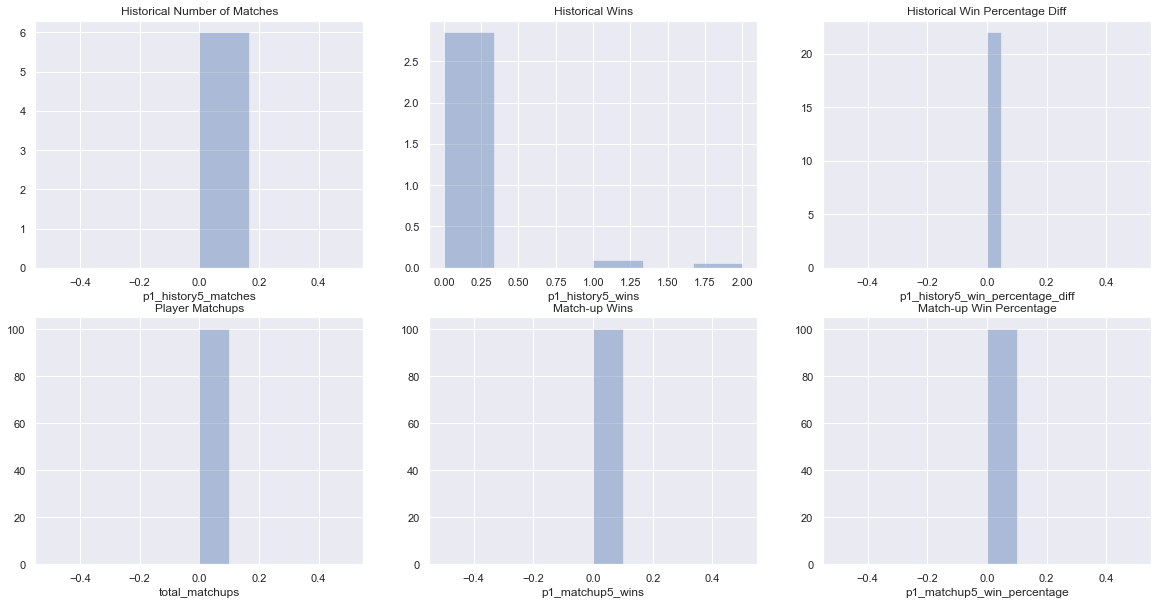

In [23]:
# distribution of player with matches
f, a = plt.subplots(2, 3, figsize=(20, 10))
sns.distplot(scores.p1_history5_matches, ax=a[0][0], bins=6, norm_hist=True, kde=False)
a[0][0].set_title("Historical Number of Matches")

sns.distplot(scores.p1_history5_wins, ax=a[0][1], bins=6, norm_hist=True, kde=False)
a[0][1].set_title("Historical Wins")

sns.distplot(scores.p1_history5_win_percentage_diff, ax=a[0][2], bins=22, norm_hist=True, kde=False)
_ = a[0][2].set_title("Historical Win Percentage Diff")


sns.distplot(scores.total_matchups, ax=a[1][0], kde=False)
_ = a[1][0].set_title("Player Matchups")

sns.distplot(scores.p1_matchup5_wins, ax=a[1][1], kde=False)
_ = a[1][1].set_title("Match-up Wins")

sns.distplot(scores.p1_matchup5_win_percentage, ax=a[1][2], kde=False)
_ = a[1][2].set_title("Match-up Win Percentage")


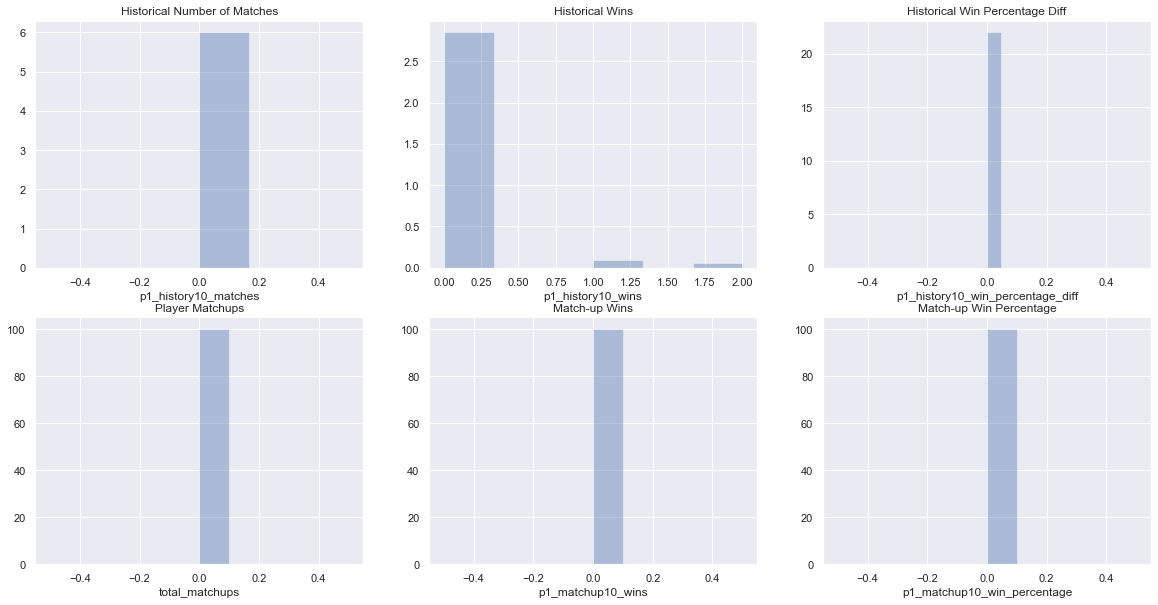

In [24]:
# distribution of player with matches
f, a = plt.subplots(2, 3, figsize=(20, 10))
sns.distplot(scores.p1_history10_matches, ax=a[0][0], bins=6, norm_hist=True, kde=False)
a[0][0].set_title("Historical Number of Matches")

sns.distplot(scores.p1_history10_wins, ax=a[0][1], bins=6, norm_hist=True, kde=False)
a[0][1].set_title("Historical Wins")

sns.distplot(scores.p1_history10_win_percentage_diff, ax=a[0][2], bins=22, norm_hist=True, kde=False)
_ = a[0][2].set_title("Historical Win Percentage Diff")


sns.distplot(scores.total_matchups, ax=a[1][0], kde=False)
_ = a[1][0].set_title("Player Matchups")

sns.distplot(scores.p1_matchup10_wins, ax=a[1][1], kde=False)
_ = a[1][1].set_title("Match-up Wins")

sns.distplot(scores.p1_matchup10_win_percentage, ax=a[1][2], kde=False)
_ = a[1][2].set_title("Match-up Win Percentage")


## Player Stats

In [25]:
stats_avg.describe()

,player_id,stats_ace_avg,stats_df_avg,stats_svpt_avg,stats_1stin_avg,stats_1stwon_avg,stats_2ndwon_avg,stats_svgms_avg,stats_bpsaved_avg,stats_bpfaced_avg,stats_ace_percentage_avg,stats_1stin_percentage_avg,stats_bpsaved_percentage_avg
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,113019.629213,6.297753,2.847378,75.533708,47.243258,33.659176,14.154682,11.691948,3.826404,6.332397,0.082823,0.623246,0.531526
std,20614.460488,4.815253,1.786992,17.011164,11.683932,9.143114,4.295190,2.276556,2.101372,2.597423,0.062450,0.065601,0.198654
min,103333.000000,0.000000,0.000000,25.500000,18.500000,13.000000,5.000000,4.000000,0.000000,1.500000,0.000000,0.475410,0.000000
25%,104925.000000,3.000000,1.666667,64.000000,39.750000,27.750000,11.400000,10.000000,2.500000,4.500000,0.040816,0.587327,0.428571
50%,105614.000000,5.666667,2.500000,73.000000,46.000000,34.333333,14.000000,11.500000,3.500000,6.000000,0.072871,0.630137,0.559524
75%,111202.000000,8.000000,4.000000,86.500000,53.666667,40.000000,17.000000,13.000000,5.333333,8.000000,0.099364,0.665152,0.666667
max,200615.000000,26.000000,8.000000,113.000000,78.000000,52.500000,27.000000,17.000000,11.000000,16.000000,0.309524,0.759091,0.893333


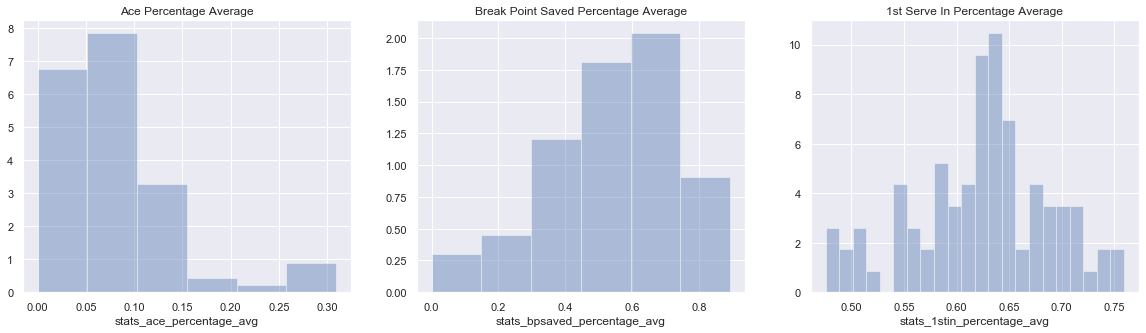

In [26]:
f, a = plt.subplots(1, 3, figsize=(20, 5))
sns.distplot(stats_avg.stats_ace_percentage_avg, ax=a[0], bins=6, norm_hist=True, kde=False)
a[0].set_title("Ace Percentage Average")

sns.distplot(stats_avg.stats_bpsaved_percentage_avg, ax=a[1], bins=6, norm_hist=True, kde=False)
a[1].set_title("Break Point Saved Percentage Average")

sns.distplot(stats_avg.stats_1stin_percentage_avg, ax=a[2], bins=22, norm_hist=True, kde=False)
_ = a[2].set_title("1st Serve In Percentage Average")

In [27]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-24 10:05
